# Bayesian Modelling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

$ P(\frac{Param}{Data}) = P(\frac{Data}{Param}) P(Param)$

Posterior = Likelihood x Prior

(Norm constant ignored)

# Conjugate (Prior is conj to Likelihood if Posterior comes from same distribution as Prior)

## Beta-Binomial Conjugate

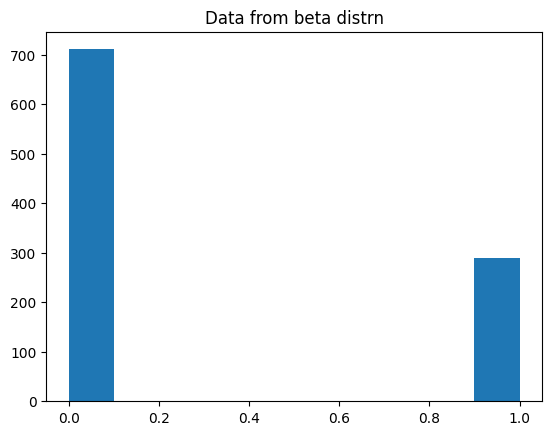

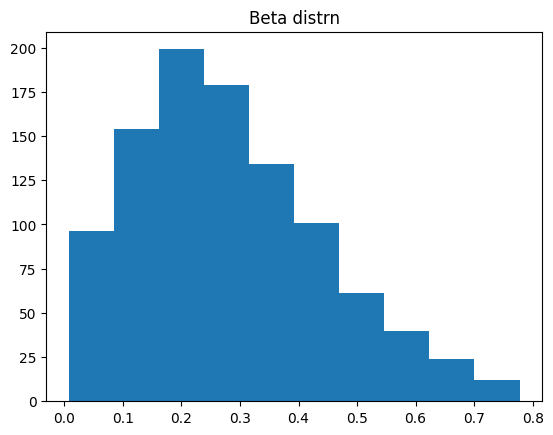

In [3]:
alpha = 2; beta = 5
N = 1000
random_beta_distr = np.random.beta(alpha, beta, N)
random_data = np.random.binomial(1, random_beta_distr, N)

plt.hist(random_data);  plt.title('Data from beta distrn'); plt.show()
plt.hist(random_beta_distr); plt.title('Beta distrn'); plt.show()


## Derivation of alpha posterior, beta posterior

We assume:
1.  the probabilities of parameters(**Priors**) are picked from Beta-Distribution
2. The Distribution of *data given the parameters*(**likelihood**) is picked from Binomial distribution

## Priors come from Beta Distribution
$ \pi(\theta) = \theta^{\alpha - 1} \cdot (1 - \theta)^{\beta - 1}$ 

RHS divided by Normalizing constant, which is ignored

## Likelihood

$ \pi(\frac{X}{\theta}) = \binom{N}{X} \cdot \theta^{X} \cdot (1 - \theta)^{N - X}  $ 

(X is number of successful trials)

## Posterior
$
\begin{align*}
    \pi\left(\frac{\theta}{X}\right) &= \pi\left(\frac{X}{\theta}\right) \cdot \pi(\theta) \\
    &= \binom{N}{X} \cdot \theta^X \cdot (1 - \theta)^{N - X} \cdot \theta^{\alpha - 1} \cdot (1 - \theta)^{\beta - 1} \\
    &= \theta^{\alpha + X - 1} \cdot (1 - \theta)^{\beta + N - X - 1} \cdot NormalizingConst
\end{align*}

$


Since, new posteriors are also from beta-distribution(the idea of conjugate that prior and posterior are from same distribution)
new params

$ \alpha = \alpha + X $ (where X is number of successful trials) 


$ \beta = \beta +  N - X $ (where N is number of trials) 

In [10]:
# Priors
alpha_prior = 1
beta_prior = 1

In [11]:
# Update Posteriors' based on above derivation
X = np.sum(random_data)
alpha_post = alpha_prior + X
beta_post = beta_prior + N - X 

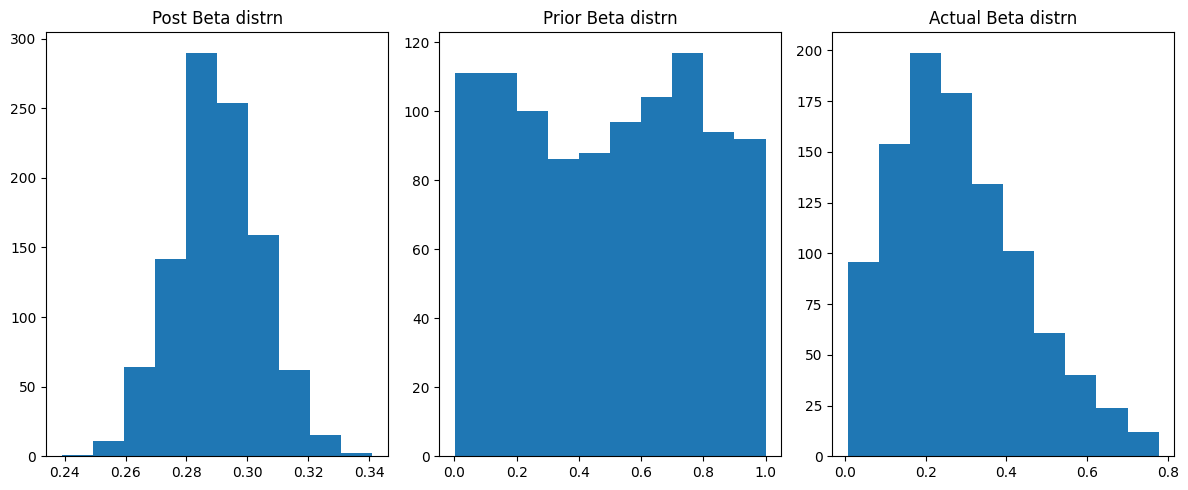

In [17]:
prior_prob = np.random.beta(alpha_prior, beta_prior, N)
posterior_prob = np.random.beta(alpha_post, beta_post, N)

fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].hist(posterior_prob);ax[0].set_title('Post Beta distrn')
ax[1].hist(prior_prob); ax[1].set_title('Prior Beta distrn')
ax[2].hist(random_beta_distr);ax[2].set_title('Actual Beta distrn')

plt.tight_layout();plt.show()

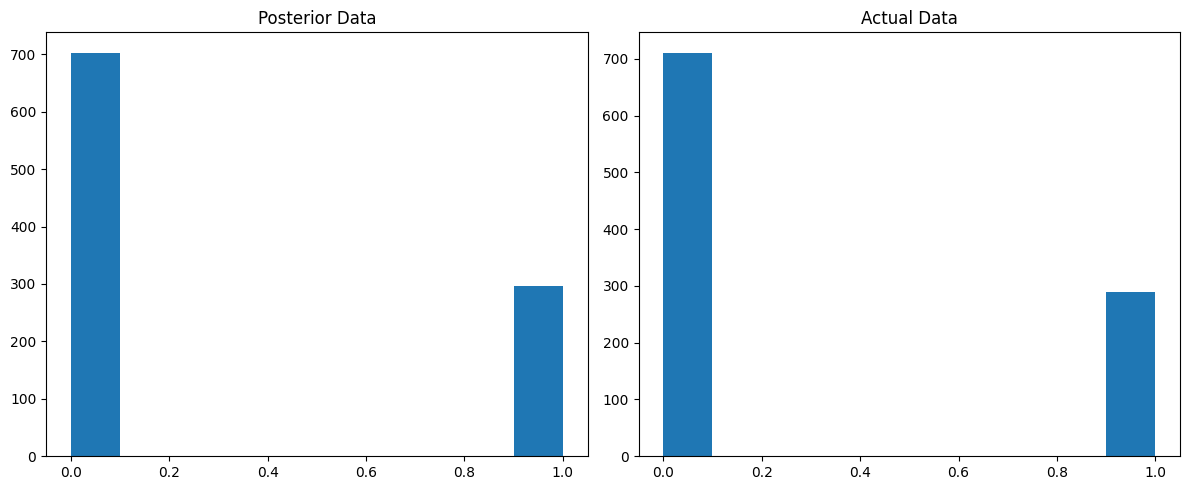

In [16]:
posterior_data = np.random.binomial(1, posterior_prob, N)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(posterior_data);ax[0].set_title('Posterior Data')
ax[1].hist(random_data); ax[1].set_title('Actual Data')

plt.tight_layout();plt.show()

## Similarly, for Poisson-Gamma Conjugate

**Priors come from Gamma Distr**

$ \frac{\beta^\alpha}{\Gamma(k)} \cdot \lambda^{\alpha-1} e^{-\beta \lambda}$ 

**Likelihood from possion(Since independent, Prob of observing **X** vector data is product of independent poisson prob)**

$ \pi(\frac{\textbf{x}}{\lambda}) = Likelihood = \prod_{i=1}^{N} \frac{e^{-\lambda}  \cdot \lambda^{x_i}}{x_i !}  = \frac{e^{-\lambda \cdot N} \cdot \lambda^{\sum_{i} X}}{\prod_{i} x_i !}$

**Posterior**
Posterior = Likelihood X Prior

$ Posterior = \lambda^{\alpha + \sum_{i} x - 1} \cdot e^{-\lambda{(\beta + N)}}$



Conjugate assumption: The posteriors are also from Gamma distribution with NEW parameters being

$  \lambda = \beta + N $

$ \alpha = \alpha + \sum_{i} x $ 

## For Normal, its a bit complicated
https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture5.pdf

## MCMC

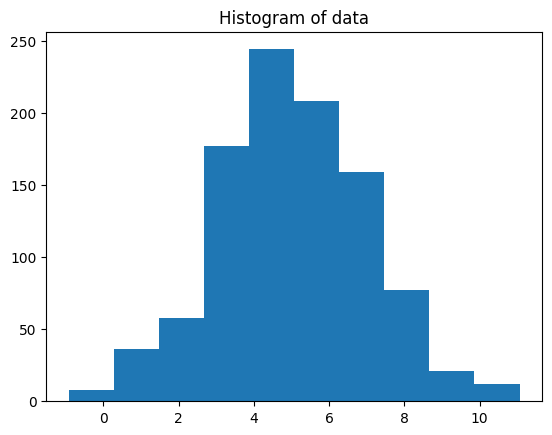

In [3]:
# Generate data
mu = 5; sigma = 2
N = 1000

data = np.random.normal(mu, sigma, N)

plt.hist(data); plt.title('Histogram of data'); plt.show()

### In this case, it is Normal-Normal conjugate. But let's pretend its not to simulate MCMC

## Pseudocode
1. Assuming **Normal distr**(You have to have some model of the data). Guess the Initial values of the parameters: $ \mu_0, \sigma_0 $
2. For each simulation:

    0. Current point is $\mu, \sigma$
    1. Propose a new point in plane: $\mu', \sigma' $ picking from $ N(\mu, \sigma_{\mu}) $ and $ N(\sigma, \sigma_{\sigma}) $  respectively
    2. See  if Likelihood(Data/$\mu', \sigma' $) > Likelihood(Data/$\mu, \sigma $)
    3.  if yes, accept the new params and repeat from (1) 
    4. Else accept the new param with probability(P_ratio): Likelihood(Data/$\mu', \sigma' $)/Likelihood(Data/$\mu, \sigma $){This means Generate a random number between 0 and 1: `u`. If  P_ratio is less than u, then acept new param. Else stay there}

    (This calculation of P_ratio and `u` is necessary because you don't want your param to stuck at local minima) 
    

In [15]:
# params

# initial points - mu and sigma at t = 0
mu_0 = 1; sigma_0 = 1

# std of the proposed mean and sigma
sigma_mu = 0.5; sigma_sigma = 0.5

# number of simulations
N = 100

In [16]:
def log_likelihood(x, mu, sigma):
    """
    x is the data vector
    we want to calculate P(Data/params) = P(X/mu, sigma) = P(x1/mu,sigma) x P(x2/mu,sigma) x ... P(xn/mu,sigma)
    """

    return np.sum(np.log(1/(np.sqrt(2*np.pi*sigma**2))*np.exp(-(x-mu)**2/(2*sigma**2))))
    
    

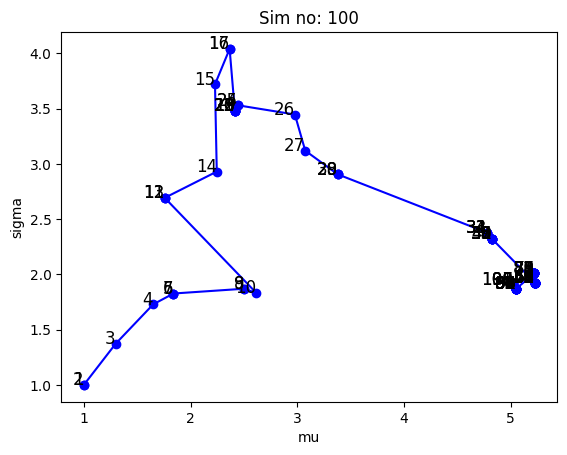

In [17]:
# current param
mu = mu_0; sigma = sigma_0
all_traversed_params = [ (mu, sigma) ]

for sim_no in range(N):
    # sample new mu and sigma from Normal distr
    # mu ~ N(mu(t), SIGMA_MU), sigma ~ N(sigma(t), SIGMA_SIGMA). the SIGMAs are params chosen by us
    mu_prime = np.random.normal(mu, sigma_mu)
    sigma_prime = np.random.normal(sigma, sigma_sigma)
    
    # likelikhood of new point
    p_prime = log_likelihood(data, mu_prime, sigma_prime)
    p_current = log_likelihood(data, mu, sigma)

    if p_prime >= p_current:
        # accept new point
        mu = mu_prime
        sigma = sigma_prime
    else:
        # accept the point with prob P_prime/P_current
        # this will help the param to NOT get stuck at local minima, else params will be stuck
        u = np.random.uniform(0, 1)
        if np.exp(p_prime)/np.exp(p_current) < u:
            mu = mu_prime
            sigma = sigma_prime
        else:
            mu = mu
            sigma = sigma
    
    all_traversed_params.append((mu, sigma))


    clear_output(wait=True)
    mu_values = [mu for mu, sigma in all_traversed_params]
    sigma_values = [sigma for mu, sigma in all_traversed_params]
    plt.plot(mu_values, sigma_values, 'bo-', label='Traversal Path')
    for i, (mu, sigma) in enumerate(all_traversed_params):
        plt.text(mu, sigma, f'{i+1}', fontsize=12, ha='right')

    plt.xlabel('mu');  plt.ylabel('sigma'); plt.title(f'Sim no: {sim_no + 1}'); plt.show()

    

      

In [18]:
all_traversed_params[-1]
# original: mu = 5; sigma = 2

(5.019237119688174, 1.9106690983198333)

# Motivation for Likelihood-free inference algo

If we know the likelihood and prior, and when we multiply them and get a posterior such that the **family distribution of Posterior** is same as **family distriubtion of prior**(jargon: prior and likelihood are "conjugate" ), then we can directly udpate the params of the posterior family distriubtion like we did in the beginning.

Example: Prior: Beta Distr, Likelihood: Binomial, Posterior: Beta

But if they are NOT conjugate,then we use sampling algos like MCMC, where we do a random walk in parameter space. We sample a new param, see if the likelihood of this new param is greater than current param. If so, then jump to the next param.

But, what if the likelihood is not known? This gives a new class of algorithms called "Simulation based Inference"

## The idea:

You don't know likelihood, so let's FIRST find a family of distribution for likelihood(say binomial, call it $q_p$)

Now, you need to find "p" for your binomial distribution.

You want to find "p" of Binomial distribution such that $q_p$ approximates the true likelihood  $P(\frac{Data}{{Params}})$

The problem boils down to find params of q(like "p" in binomial) so that q(Data/params) is maximized.

But the question is where do you find q(Data/params). The Answer: YOU CREATE IT!

## Algo:

1. Sample params from Prior distribution
2. You have a model of the data. Feed params into the model, and get synthetic data.


Now, you have to find params of posterior family distribution($p$ in binomial). The relation between priors and likelihood params is non linear and complicated. So train a neural network that learns mapping from params to likelihood params.

Once you have the likelihood params, perform MCMC to do a posterior probs

This method is called Neural Likelihood esimtation(You are using a neural network to learn likelihood)

Alternate:

You can directly approximate the posterior family of distriubtions and train the NN to learn mapping from prior to posterior. This is called Neural Posterior Estimation(Using NN to estimate Posterior).

# SNPE(Sequential Neural Posterior Estimate) - INCOMPLETE

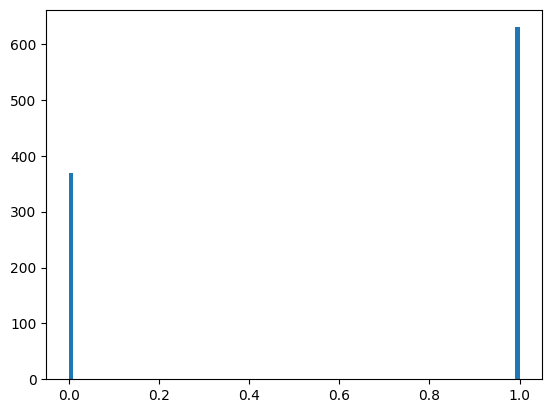

In [2]:
# Generate Data
true_params = np.array([0.1, 0.4, 0.9])

x = np.array(np.random.uniform(0,1,3))

p = 1.0 / (1.0 + np.exp(-(np.dot(x, true_params))))

data = np.random.binomial(1, p, size=1000)

# histogram of data
plt.hist(data, bins=100)
plt.show()

In [3]:
# Sample priors and obtain synthetic data

N_rounds = 10000
synthetic_data = np.zeros((N_rounds, 1000))
params_arr = np.zeros((N_rounds, 3))

for round in range(N_rounds):
    # choose one element randomly from prior_param1
    params_sample = np.array([np.random.uniform(0,1) for _ in range(3)])
    params_arr[round, :] = params_sample

    y_sigmoid = 1/(1 + np.exp(-np.dot(x, params_sample)))
    synthetic_data[round, :] = np.random.binomial(1, y_sigmoid, size= 1000)

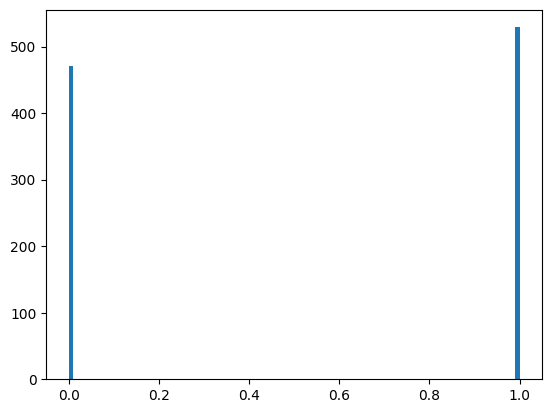

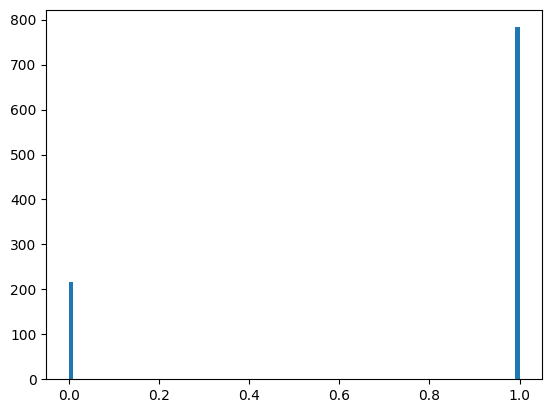

In [4]:
# check random couple rounds data of synthetic data: histogram

plt.hist(synthetic_data[34,:], bins=100); plt.show()
plt.hist(synthetic_data[897,:], bins=100); plt.show()


In [5]:
## a neural network is trained to learn mapping from params: param1, bias -> "p"
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(3, 32)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.act2 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        return x

In [10]:
model = NeuralNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

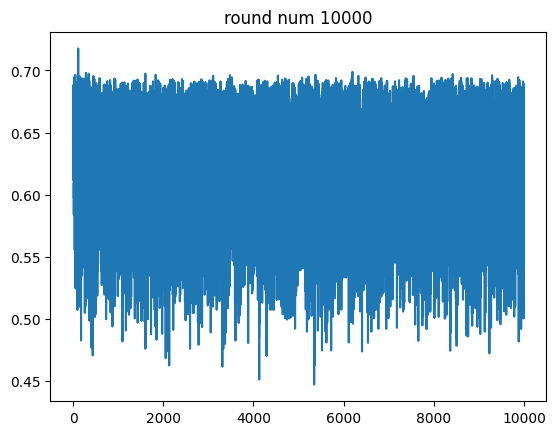

In [7]:
loss_arr = []

for round in range(N_rounds):
    # data round
   
    round_params = params_arr[round,:]
    round_data = synthetic_data[round,:]

    param_tensor = torch.tensor(round_params, dtype=torch.float)
    nn_output = model(param_tensor)

    # cal loss
    optimizer.zero_grad()

    # q = p^ x  1 - p ^ (1 - X). compact notation of x = 1 with prob p and x = 0 with prob 1 - p
    loss =  (-1/len(round_data)) * torch.sum(torch.log(nn_output + 1e-8) * torch.tensor(round_data) + torch.log(1-nn_output + 1e-8) * torch.tensor(1-round_data))
    # backprop
    loss.backward()
    optimizer.step()

    loss_arr.append(loss.item())
    if round % 100 == 0 or round == N_rounds - 1:
        clear_output(wait=True)
        plt.plot(loss_arr); plt.title(f"round num {round+1}"); plt.show()




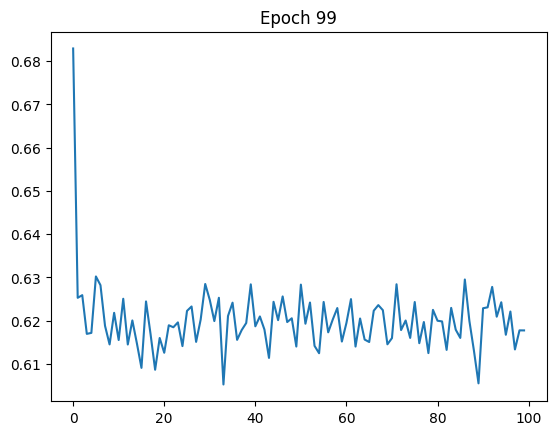

In [11]:
# Trying epochs
loss_arr = []
batch_size = 100  # Define batch size
num_batches = N_rounds // batch_size
plot_frequency = 10  # Plot after every 10 batches (1000 examples)

for epoch in range(num_batches):
    batch_loss = 0.0
    
    for i in range(batch_size):
        round = epoch * batch_size + i
        
        # Retrieve the parameters and data for the current batch
        round_params = params_arr[round, :]
        round_data = synthetic_data[round, :]

        param_tensor = torch.tensor(round_params, dtype=torch.float32)
        round_data_tensor = torch.tensor(round_data, dtype=torch.float32)

        nn_output = model(param_tensor)

        # Calculate loss
        optimizer.zero_grad()
        epsilon = 1e-8  # Add epsilon to avoid log(0)
        nn_output = nn_output.squeeze()  # Remove extra dimension if any
        loss = (-1 / len(round_data_tensor)) * torch.sum(
            torch.log(nn_output + epsilon) * round_data_tensor + torch.log(1 - nn_output + epsilon) * (1 - round_data_tensor)
        )

        # Backpropagation
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
    
    # Average loss over the batch
    batch_loss /= batch_size
    loss_arr.append(batch_loss)
    
    # Plot after every 10 batches (1000 examples)
    clear_output(wait=True)
    if epoch % plot_frequency == 0 or epoch == num_batches - 1:
        plt.plot(loss_arr)
        plt.title(f"Epoch {epoch}")
        plt.show()


# Kernel Density Estimator - To estimate likelihoods that are considered as ground truth

(array([  1.,   5.,  45., 102., 172., 241., 225., 143.,  51.,  15.]),
 array([-1.95176207, -0.72962726,  0.49250756,  1.71464237,  2.93677719,
         4.158912  ,  5.38104682,  6.60318163,  7.82531645,  9.04745126,
        10.26958608]),
 <BarContainer object of 10 artists>)

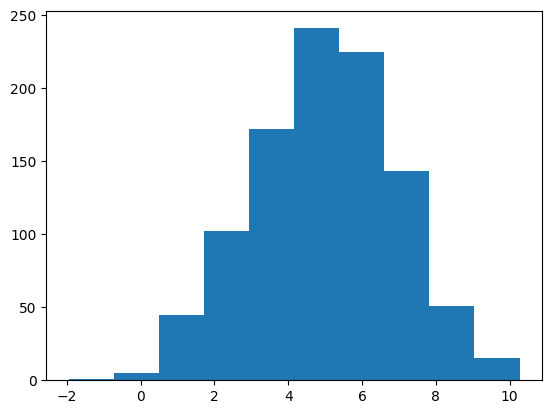

In [40]:
N = 1000
# generate 100 normal points
x = np.random.normal(5, 2, N)
# plot to see
plt.hist(x)

In [41]:
def kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u ** 2)

In [42]:
# Kernel density estimator
density_curve = []
h = 0.5
x_grid = np.linspace(-2, 11, 10000)
for i in range(0, len(x_grid)):
    f_hat = 0
    for j in range(N):
        f_hat += kernel((x_grid[i] - x[j])/h)
    
    f_hat = f_hat/(N * h)

    density_curve.append(f_hat)

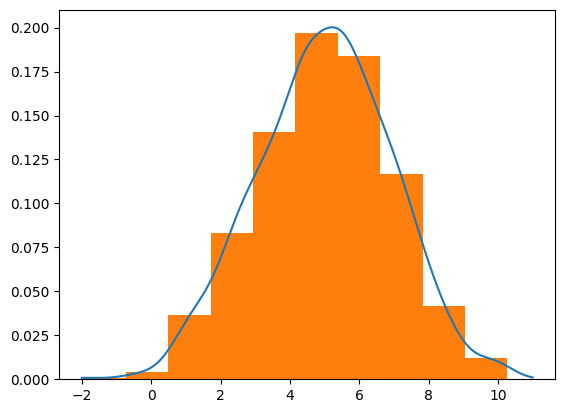

In [43]:
# plot density curve
plt.plot(x_grid,density_curve)
# plot histogram of x on the same curve
plt.hist(x, density=True)
plt.show()

For each point in x_grid, you see what is the probabilility that it belongs to each point in x(actual data). here you are assuming the each grid point is picked from gaussian distribution of that point.

Around the mean points the prob is high so they will have high values. Far from mean, the prob is low so they will have low values.

In [44]:
# find the mean and std to compare how good
# mean: x * p(x)

# integral of p(x) dx = 1
dx =  (x_grid[-1] - x_grid[0]) / len(x_grid)

# density curve to numpy  arr
density_curve = np.array(density_curve)


# Integral of p(x) dx should be 1
int_px = np.sum(density_curve * dx)

# Mean
mean_px = np.sum(x_grid * density_curve * dx)

# Variance
var_px = np.sum(((x_grid - mean_px) ** 2) * density_curve * dx)

print('Original mean: ', np.mean(x), ' Var: ', np.var(x), ' std: ', np.std(x))
print('KDE mean: ', mean_px, ' Var: ', var_px)
print('Integral of p(x) dx: ', int_px)

Original mean:  4.996338777708787  Var:  3.7232022055735166  std:  1.9295601067532249
KDE mean:  4.994365912314774  Var:  3.9386294590817306
Integral of p(x) dx:  0.9992049660453679


Note that the kernel need NOT match with data distribution. Data can be poisson and kernel can still be gaussian. Because Kernel is for smoothing at each bin. Not for entire data distribution fit

# Nested Sampling

In [101]:
mu = 5
sigma = 2
N = 50

data = np.random.normal(mu, sigma, N)

In [102]:
def log_likelihood(x, mu, sigma):
    """
    x is the data vector
    we want to calculate P(Data/params) = P(X/mu, sigma) = P(x1/mu,sigma) x P(x2/mu,sigma) x ... P(xn/mu,sigma)
    """

    return np.sum(np.log(1/(np.sqrt(2*np.pi*sigma**2))*np.exp((-(x-mu)**2)/(2*sigma**2))))
    
    

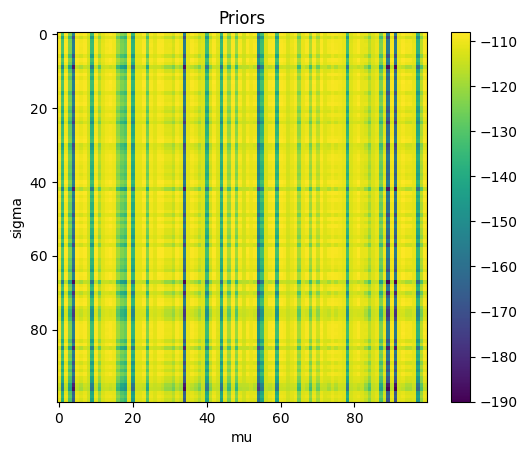

In [103]:
# PARAMS
num_live_points = 100
prior_volume = 1
volume_compression_factor = np.exp(-1/num_live_points)
evidence = 0

# priors
mu_prior = np.random.uniform(4, 6, num_live_points)
sigma_prior = np.random.uniform(1, 3, num_live_points)

# likelihood
likelihood = np.zeros((len(mu_prior), len(sigma_prior)))

for i, pi_mu in enumerate(mu_prior):
    for j, sigma_mu in enumerate(sigma_prior):
        likelihood[i,j] = log_likelihood(data, pi_mu, sigma_mu)

plt.imshow(likelihood)
plt.xlabel('mu')
plt.ylabel('sigma')
plt.title('Priors')
plt.colorbar()
plt.show()

In [104]:
def draw_better_likelihood(mu_prior, sigma_prior, old_likelihood):
    new_likelihood = -np.inf # p = 0, log p = -inf
    while new_likelihood < old_likelihood:
        new_mu = np.random.choice(mu_prior)
        new_sigma = np.random.choice(sigma_prior)
        new_likelihood = log_likelihood(data, new_mu, new_sigma)
    
    return new_likelihood

Min loglikelihood = -109.28818878720081, its exp is 3.4414595751983374e-48


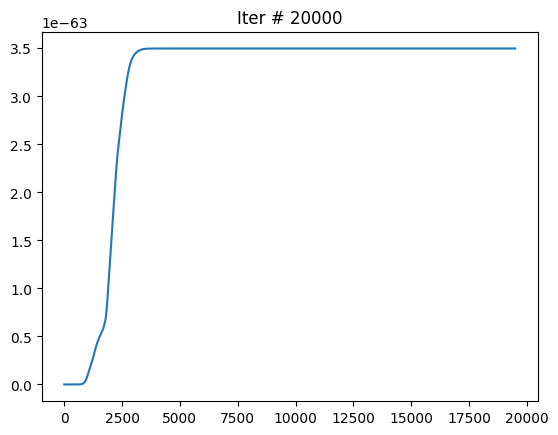

In [105]:
likelihood = likelihood.flatten()
# log_evidence = -np.inf
evidence_arr = []
for iter in range(20000):
    # get the least Likelihood
    min_likelihood_idx = np.argmin(likelihood)
    min_likelihood = likelihood[min_likelihood_idx]
    
    # draw a better likelihood to replace it
    new_replaced_likelihood = draw_better_likelihood(mu_prior, sigma_prior, min_likelihood)

    # update the likelihood
    likelihood[min_likelihood_idx] = new_replaced_likelihood

    # use the old likelihood to multiply it with dV and add its contribution to evidence
    dV = prior_volume - volume_compression_factor*prior_volume
    evidence += np.exp(min_likelihood)*dV
    # adjustments for numerical ans
    # log_weight = np.log(dV) + min_likelihood
    # log_evidence = np.logaddexp(log_evidence, log_weight)
    # evidence += np.exp(log_evidence)


    # update the volume
    prior_volume *= volume_compression_factor

    evidence_arr.append(evidence)
    clear_output(wait=True)
    if iter % 500 == 0:
        print(f"Min loglikelihood = {min_likelihood}, its exp is {np.exp(min_likelihood)}")
        plt.plot(evidence_arr); plt.title(f"Iter # {iter+500}") ;plt.show()
    

In [112]:
# volume correctly reduced
print(prior_volume/(volume_compression_factor**20e3))
print(evidence)

1.0000000000000062
3.4984864248291183e-63


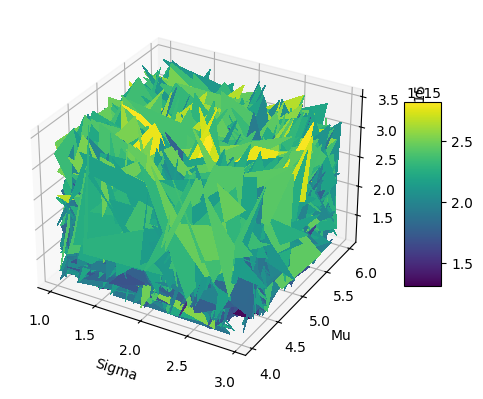

In [122]:
log_posterior = likelihood - np.log(evidence)
posterior =  np.exp(log_posterior)

posterior_norm = posterior/np.sum(posterior)
posterior_reshaped = posterior.reshape(len(mu_prior), len(sigma_prior))

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the meshgrid
X, Y = np.meshgrid(sigma_prior, mu_prior)

# Plot the surface
surf = ax.plot_surface(X, Y, posterior_reshaped, cmap=cm.viridis,
                       linewidth=0, antialiased=False)

# Customize the axes
ax.set_xlabel('Sigma')
ax.set_ylabel('Mu')
ax.set_zlabel('Posterior')

# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

